## DFO Nutrient Comparison
### spring2015_diatHS

In [1]:
import sqlalchemy
from sqlalchemy import (create_engine, Column, String, Integer, Float, MetaData, 
                        Table, type_coerce, ForeignKey, case)
from sqlalchemy.orm import mapper, create_session, relationship, aliased, Session
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import case
import numpy as np
from sqlalchemy.ext.automap import automap_base
import matplotlib.pyplot as plt
import sqlalchemy.types as types
from sqlalchemy.sql import and_, or_, not_, func
from sqlalchemy.sql import select
import os
from os.path import isfile
import pandas as pd
import netCDF4 as nc
import datetime as dt

%matplotlib inline

In [2]:

PATH= '/data/eolson/MEOPAR/SS36runs/CedarRuns/spring2015_diatHS/'

In [3]:
# definitions
basepath='/ocean/eolson/MEOPAR/obs/'
basedir=basepath + 'DFOOPDB/'
dbname='DFO_OcProfDB'
# if db does not exist, exit
if not isfile(basedir + dbname + '.sqlite'):
    print('ERROR: ' + dbname + '.sqlite does not exist')
engine = create_engine('sqlite:///' + basedir + dbname + '.sqlite', echo = False)
Base = automap_base()
# reflect the tables in salish.sqlite:
Base.prepare(engine, reflect=True)
# mapped classes have been created

# existing tables:
StationTBL=Base.classes.StationTBL
ObsTBL=Base.classes.ObsTBL
CalcsTBL=Base.classes.CalcsTBL
JDFLocsTBL=Base.classes.JDFLocsTBL

session = create_session(bind = engine, autocommit = False, autoflush = True)


In [4]:
qry0=(session
      .query(StationTBL.StartTimeZone.label('TimeZone'))
      .filter(StationTBL.StartYear>2014)
      .group_by(StationTBL.StartTimeZone))

In [5]:
for row in qry0.all():
    print(row)
    # one value means time zone is the same for all data for 2015 on

('UTC',)


In [6]:
SA=case([(CalcsTBL.Salinity_Bottle_SA!=None, CalcsTBL.Salinity_Bottle_SA)], else_=
         case([(CalcsTBL.Salinity_T0_C0_SA!=None, CalcsTBL.Salinity_T0_C0_SA)], else_=
         case([(CalcsTBL.Salinity_T1_C1_SA!=None, CalcsTBL.Salinity_T1_C1_SA)], else_=
         case([(CalcsTBL.Salinity_SA!=None, CalcsTBL.Salinity_SA)], else_=
         case([(CalcsTBL.Salinity__Unknown_SA!=None, CalcsTBL.Salinity__Unknown_SA)], 
              else_=CalcsTBL.Salinity__Pre1978_SA)
        ))))

In [7]:
Tem=case([(ObsTBL.Temperature!=None, ObsTBL.Temperature)], else_=
         case([(ObsTBL.Temperature_Primary!=None, ObsTBL.Temperature_Primary)], else_=
         case([(ObsTBL.Temperature_Secondary!=None, ObsTBL.Temperature_Secondary)], else_=ObsTBL.Temperature_Reversing)))
TemUnits=case([(ObsTBL.Temperature!=None, ObsTBL.Temperature_units)], else_=
         case([(ObsTBL.Temperature_Primary!=None, ObsTBL.Temperature_Primary_units)], else_=
         case([(ObsTBL.Temperature_Secondary!=None, ObsTBL.Temperature_Secondary_units)], 
              else_=ObsTBL.Temperature_Reversing_units)))
TemFlag=ObsTBL.Quality_Flag_Temp

In [8]:
qry1=session.query(ObsTBL.Nitrate_plus_Nitrite_units).group_by(ObsTBL.Nitrate_plus_Nitrite_units)
for row in qry1.all():
    print(row)

(None,)
('umol/L',)


In [112]:
qry=session.query(StationTBL.StartYear.label('Year'),StationTBL.StartMonth.label('Month'),
                  StationTBL.StartDay.label('Day'),StationTBL.StartHour.label('Hour'),
                  StationTBL.Lat,StationTBL.Lon,
                 ObsTBL.Pressure,ObsTBL.Depth,ObsTBL.Ammonium,ObsTBL.Ammonium_units,ObsTBL.Chlorophyll_Extracted,
                 ObsTBL.Chlorophyll_Extracted_units,ObsTBL.Nitrate_plus_Nitrite.label('N'),
                  ObsTBL.Silicate.label('Si'),ObsTBL.Silicate_units,SA.label('AbsSal'),Tem.label('T'),TemUnits.label('T_units')).\
            select_from(StationTBL).join(ObsTBL,ObsTBL.StationTBLID==StationTBL.ID).\
            join(CalcsTBL,CalcsTBL.ObsID==ObsTBL.ID).filter(and_(ObsTBL.Silicate<100,
                                                                StationTBL.Lat>47-3/2.5*(StationTBL.Lon+123.5),
                                                                StationTBL.Lat<47-3/2.5*(StationTBL.Lon+121)))

In [113]:
df1=pd.DataFrame(qry.all())
df1.head()

,Year,Month,Day,Hour,Lat,Lon,Pressure,Depth,Ammonium,Ammonium_units,Chlorophyll_Extracted,Chlorophyll_Extracted_units,N,Si,Silicate_units,AbsSal,T,T_units
0,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,12.0,NaN,None,5.28,mg/m^3,6.6,13.6,umol/L,NaN,14.30,'deg_C_(IPTS68)'
1,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,21.5,NaN,None,0.61,mg/m^3,21.2,45.0,umol/L,NaN,10.76,'deg_C_(IPTS68)'
2,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,30.5,NaN,None,NaN,mg/m^3,23.5,47.4,umol/L,NaN,10.06,'deg_C_(IPTS68)'
3,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,52.3,NaN,None,NaN,mg/m^3,28.0,50.2,umol/L,NaN,8.85,'deg_C_(IPTS68)'
4,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,75.4,NaN,None,NaN,mg/m^3,26.5,49.1,umol/L,NaN,8.32,'deg_C_(IPTS68)'


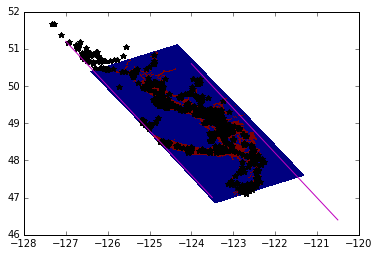

In [114]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as f:
    tmask=np.copy(f.variables['tmask'])
    lon=np.copy(f.variables['nav_lon'])
    lat=np.copy(f.variables['nav_lat'])
plt.pcolormesh(lon,lat,tmask[0,0,:,:])
plt.plot(df1.Lon,df1.Lat,'k*')
x0=-123.5
y0=47
x1=-126
y1=50
x=np.arange(-127,-123,.5)
y=y0+(y1-y0)/(x1-x0)*(x-x0) # take lat>47-3/2.5*(lon+123.5)
plt.plot(x,y,'m-')
x0=-121
y0=47
x1=-123.5
y1=50
x=np.arange(-124,-120,.5)
y=y0+(y1-y0)/(x1-x0)*(x-x0) # take lat<47-3/2.5*(lon+121)
plt.plot(x,y,'m-')

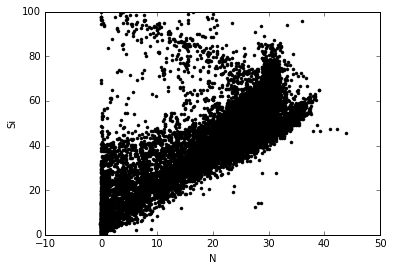

In [115]:
plt.plot(df1['N'],df1['Si'],'k.')
plt.xlabel('N')
plt.ylabel('Si')

In [116]:
from salishsea_tools import gsw_calls, viz_tools, geo_tools, tidetools
import datetime
import glob

In [117]:
depths = gsw_calls.generic_gsw_caller('gsw_z_from_p.m', 
                                      [df1.Pressure.values, df1.Lat.values])

In [118]:
depths = depths * -1

In [119]:
df1 = df1.assign(depth = depths)

In [120]:
df1.shape

(35235, 19)

In [121]:
df1.dropna(subset=['Year', 'Month', 'Hour', 'Lat', 'Lon','Pressure']).shape

(25333, 19)

In [122]:
df2 = df1.dropna(subset=['Year', 'Month', 'Hour', 'Lat', 'Lon', 'Si', 'N'])

In [123]:
deptht = (nc.Dataset(
'/results/SalishSea/nowcast-green/01jan18/SalishSea_1d_20180101_20180101_dia2_T.nc')
          .variables['deptht'][:])

In [124]:
deptht

array([   0.5000003 ,    1.5000031 ,    2.50001144,    3.50003052,
          4.50007057,    5.50015068,    6.50031042,    7.50062323,
          8.50123596,    9.50243282,   10.50476551,   11.50931168,
         12.51816654,   13.53541183,   14.56898212,   15.63428783,
         16.76117325,   18.00713539,   19.48178482,   21.38997841,
         24.10025597,   28.22991562,   34.68575668,   44.51772308,
         58.48433304,   76.58558655,   98.06295776,  121.86651611,
        147.08946228,  173.11448669,  199.57304382,  226.26029968,
        253.06663513,  279.93453979,  306.834198  ,  333.75018311,
        360.67453003,  387.60321045,  414.53408813,  441.46609497], dtype=float32)

In [125]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)
mesh = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')
start_date = datetime.datetime(2015,2,6)
end_date = datetime.datetime(2015,11,12)

In [126]:
numfiles=int(((end_date-start_date).days+1)/10)

In [127]:
numfiles

28

In [128]:
df2.shape[0]

26194

In [129]:
dates = np.array([datetime.datetime(year = int(df2.Year[n]), 
                                    month = int(df2.Month[n]),
                                    day = int(df2.Day[n]), 
                                    hour = int(df2.Hour[n]),
                                    minute = int((df2.Hour[n] - int(df2.Hour[n]))*60)) 
                  for n in df2.index])

In [130]:
np.random.randn()

-0.14652446614188913

In [131]:
df2 = df2.assign(date = dates)

(735234.0, 736330.0)

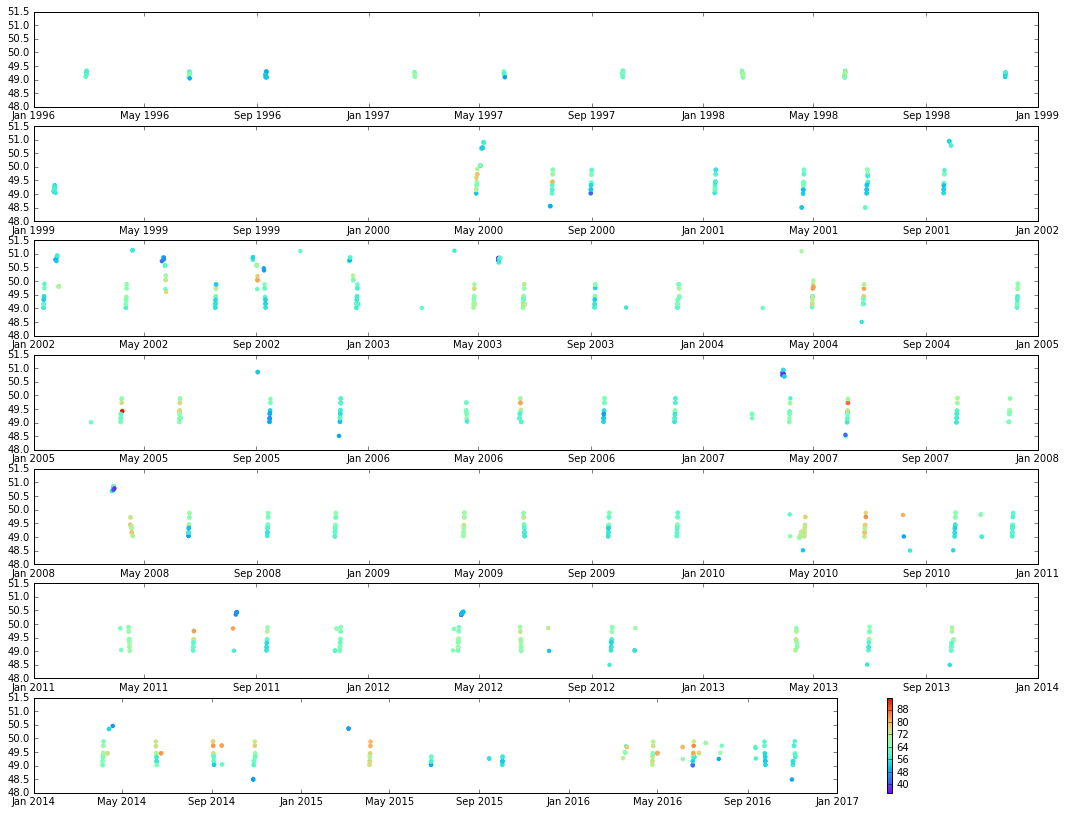

In [144]:
fig, ax = plt.subplots(7,1,figsize = (18,14))
cmap1=plt.get_cmap('rainbow')
df2[(df2.date > start_date) & (df2.date < end_date)]
idates=df2.loc[(df2.depth >250)]['date'].values
ilats=[ii+np.random.randn(1)*.01 for ii in df2.loc[(df2.depth >250)]['Lat'].values]
for ii in range(0,7):
    s=ax[ii].scatter(idates,ilats,c=df2.loc[(df2.depth >250)]['Si'].values,
           cmap=cmap1,edgecolors='none')
plt.colorbar(s)
ax[0].set_xlim(dt.datetime(1996,1,1),dt.datetime(1999,1,1))
ax[1].set_xlim(dt.datetime(1999,1,1),dt.datetime(2002,1,1))
ax[2].set_xlim(dt.datetime(2002,1,1),dt.datetime(2005,1,1))
ax[3].set_xlim(dt.datetime(2005,1,1),dt.datetime(2008,1,1))
ax[4].set_xlim(dt.datetime(2008,1,1),dt.datetime(2011,1,1))
ax[5].set_xlim(dt.datetime(2011,1,1),dt.datetime(2014,1,1))
ax[6].set_xlim(dt.datetime(2014,1,1),dt.datetime(2017,1,1))
#ax[1].set_xlim(dt.datetime(2010,1,1),dt.datetime(2017,1,1))

In [173]:
dtdates=[datetime.datetime.strptime(repr(d), "%Y-%m-%dT%H:%M:%S") for d in idates]
#idates2=[dt.datetime(200,mm,dd) for mm,dd in zip(imonths,idays)]

ValueError: time data "numpy.datetime64('2008-09-12T11:18:00.000000000')" does not match format '%Y-%m-%dT%H:%M:%S'

In [171]:
idays

array(['2008-09-12', '2008-09-12', '2008-09-12', ..., '2016-11-04',
       '2016-11-04', '2016-11-04'], dtype='datetime64[D]')

In [152]:
np.shape(imonths),np.shape(idays)

((1237,), (1237,))

AttributeError: 'numpy.ndarray' object has no attribute 'day'

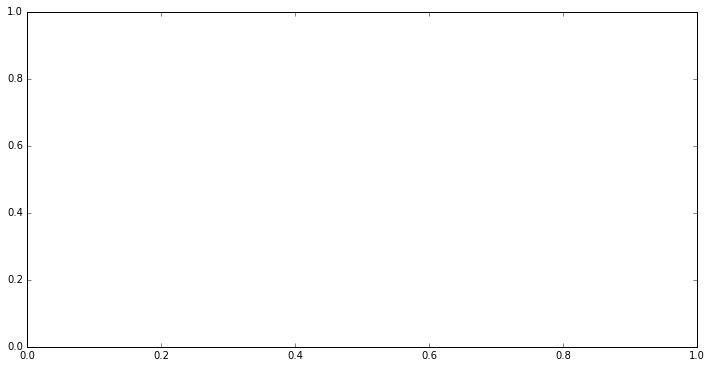

In [146]:
fig,ax=plt.subplots(1,1,figsize=(12,6))
ax.plot(idates.day(),df2.loc[(df2.depth >250)]['Si'].values)

In [28]:
bounds = np.array([start_date + datetime.timedelta(days = n*10) for n in range(numfiles+1) ])
bounds[-1]

datetime.datetime(2015, 11, 13, 0, 0)

In [29]:
bounds_r = (bounds - datetime.timedelta(days = 1))[1:]
bounds_l = bounds[:-1]

In [30]:
bounds_r[:2]

array([datetime.datetime(2015, 2, 15, 0, 0),
       datetime.datetime(2015, 2, 25, 0, 0)], dtype=object)

In [31]:
for n in range(numfiles):
    bounds_l[n] = bounds_l[n].replace(minute = 30)

In [32]:
for n in range(numfiles):
    bounds_r[n] = bounds_r[n].replace(hour = 23, minute = 30)

In [33]:
list_of_lons = np.array([])
list_of_lats = np.array([])
list_of_datetimes = np.array([])
list_of_cs_ni = np.array([])
list_of_cs_si = np.array([])
list_of_model_ni = np.array([])
list_of_model_si = np.array([])
list_of_depths = np.array([])
for n in df2[(df2.date > start_date) & (df2.date < end_date)].index:
    date = df2.date[n]
    Yind, Xind = geo_tools.find_closest_model_point(df2.Lon[n], df2.Lat[n], 
                                                    X, Y, land_mask = bathy.mask)
    depth = np.argmin(np.abs(deptht - df2.depth[n]))
    if mesh.variables['tmask'][0,depth,Yind, Xind] == 1:
        for m in range(numfiles):
            if (date > bounds[m]) & (date < bounds[m+1]):
                here = m
        datestr_l = bounds_l[here].strftime('%Y%m%d')
        datestr_r = bounds_r[here].strftime('%Y%m%d')
        datestr = datestr_l + '-' + datestr_r
        nuts = nc.Dataset(glob.glob(PATH + 'SalishSea*1h*ptrc_T*' + datestr +'.nc')[0])
        if date.minute < 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                               hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
        if date.minute >= 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30)
        delta = (date.minute) / 60
        hour = (before - bounds_l[here]).days * 24 + int((before - bounds_l[here]).seconds / 60 / 60)
        ni_val = (delta*(nuts.variables['nitrate'][hour, depth, Yind, Xind] ) + 
                   (1- delta)*(nuts.variables['nitrate'][hour+1, depth, Yind, Xind] ))
        si_val = (delta*(nuts.variables['silicon'][hour, depth, Yind, Xind] ) + 
                   (1- delta)*(nuts.variables['silicon'][hour+1, depth, Yind, Xind] ))
        list_of_lons = np.append(list_of_lons, df2.Lon[n])
        list_of_lats = np.append(list_of_lats, df2.Lat[n])
        list_of_datetimes = np.append(list_of_datetimes, date)
        list_of_cs_ni = np.append(list_of_cs_ni, float(df2['N'][n]))
        list_of_cs_si = np.append(list_of_cs_si, float(df2['Si'][n]))
        list_of_model_ni = np.append(list_of_model_ni, ni_val)
        list_of_model_si = np.append(list_of_model_si, si_val)
        #list_of_depths = np.append(list_of_depths, depth)
        list_of_depths = np.append(list_of_depths, df2.depth[n])

In [34]:
df2.depth[n]

2.7761999999999998

In [35]:
list_of_cs_ni.shape

(560,)

In [36]:
print('shallow nutrient samples', list_of_cs_ni[list_of_depths < 15].shape)

shallow nutrient samples (136,)


In [37]:
print('intermediate nutrient samples',  list_of_cs_ni[(22 > list_of_depths) & (list_of_depths >= 15)].shape)

intermediate nutrient samples (41,)


In [38]:
print('deep nutrient samples',  list_of_cs_ni[list_of_depths >= 22].shape)

deep nutrient samples (383,)


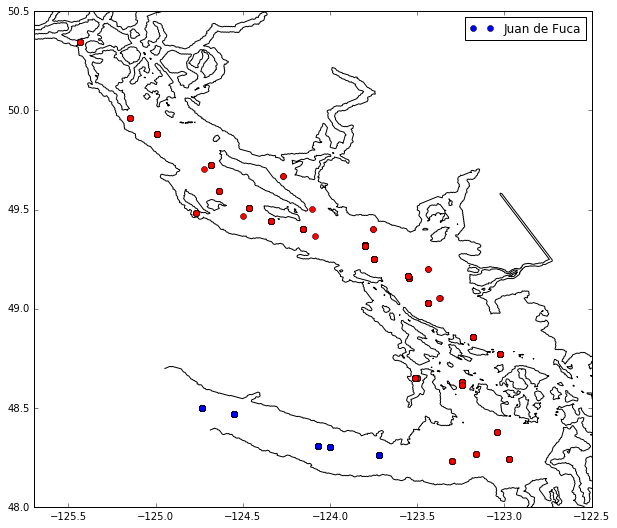

In [39]:
fig, ax = plt.subplots(figsize = (10,10))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(list_of_lons, list_of_lats, 'ro')
ax.plot(list_of_lons[(list_of_lons < -123.5) & (list_of_lats < 48.6)], 
        list_of_lats[(list_of_lons < -123.5) & (list_of_lats < 48.6)], 
        'bo', label = 'Juan de Fuca')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48, 50.5)
ax.legend()
ax.set_xlim(-125.7, -122.5);

surface bias =  -3.21822699032
surface RMSE = 6.69699265114
surface Willmott = 0.825319581044
intermediate bias =  -1.96165773539
intermediate RMSE = 5.19479735552
intermediate Willmott = 0.660073077643
deep bias =  -0.841461640932
deep RMSE = 3.74468316314
deep Willmott = 0.744727076161
bias =  -1.50069043984
RMSE = 4.73902096818
Willmott = 0.910992489749


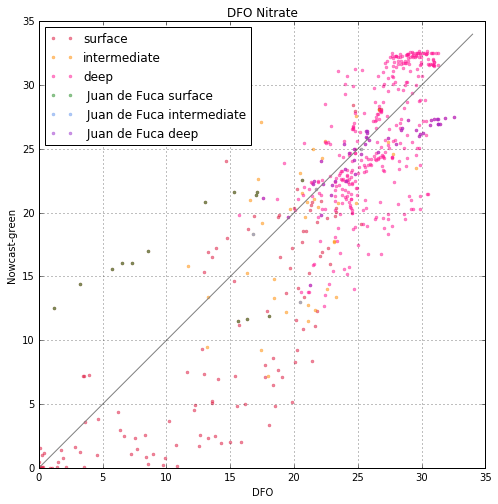

In [40]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(list_of_cs_ni[list_of_depths < 15], list_of_model_ni[list_of_depths < 15], 
        '.', color = 'Crimson', alpha = 0.5, label = 'surface')
ax.plot(list_of_cs_ni[(22 > list_of_depths) & (list_of_depths >= 15)], 
        list_of_model_ni[(22 > list_of_depths) & (list_of_depths >= 15)], 
        '.', color = 'DarkOrange', alpha = 0.5, label = 'intermediate')
ax.plot(list_of_cs_ni[list_of_depths >= 22], list_of_model_ni[list_of_depths >= 22], 
        '.', color = 'DeepPink', alpha = 0.5, label = 'deep')

ax.plot(list_of_cs_ni[(list_of_depths < 15) & (list_of_lons < -123.5) & (list_of_lats < 48.6)], 
        list_of_model_ni[(list_of_depths < 15) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.6)], 
        '.', color = 'ForestGreen', alpha = 0.5, label = ' Juan de Fuca surface')
ax.plot(list_of_cs_ni[(22 > list_of_depths) & (list_of_depths >= 15) 
                      & (list_of_lons < -123.5) & (list_of_lats < 48.6)], 
        list_of_model_ni[(22 > list_of_depths) & (list_of_depths >= 15) 
                         & (list_of_lons < -123.5) & (list_of_lats < 48.6)], 
        '.', color = 'CornflowerBlue', alpha = 0.5, label = ' Juan de Fuca intermediate')
ax.plot(list_of_cs_ni[(list_of_depths >= 22) & (list_of_lons < -123.5) & (list_of_lats < 48.6)], 
        list_of_model_ni[(list_of_depths >= 22) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.6)], 
        '.', color = 'DarkOrchid', alpha = 0.5, label = ' Juan de Fuca deep')

ax.plot(np.arange(0,35), color = 'grey')
ax.grid('on')
ax.set_title('DFO Nitrate')
ax.set_xlabel('DFO')
ax.set_ylabel('Nowcast-green');
ax.legend(loc=2)
print('surface bias =  ' + str(-np.mean(list_of_cs_ni[list_of_depths < 15]) 
                               + np.mean(list_of_model_ni[list_of_depths < 15])))
print('surface RMSE = ' + str(np.sqrt(np.sum((list_of_model_ni[list_of_depths < 15] 
                                              - list_of_cs_ni[list_of_depths < 15])**2) /
                              len(list_of_cs_ni[list_of_depths < 15]))))
xbar = np.mean(list_of_cs_ni[list_of_depths < 15])
print('surface Willmott = ' + str(1-(np.sum((list_of_model_ni[list_of_depths < 15] 
                                             - list_of_cs_ni[list_of_depths < 15])**2)  / 
                             np.sum((np.abs(list_of_model_ni[list_of_depths < 15] - xbar) 
                                     + np.abs(list_of_cs_ni[list_of_depths < 15] - xbar))**2))))

print('intermediate bias =  ' + str(-np.mean(list_of_cs_ni[(22 > list_of_depths) 
                                                           & (list_of_depths >= 15)]) 
                               + np.mean(list_of_model_ni[(22 > list_of_depths) 
                                                          & (list_of_depths >= 15)])))
print('intermediate RMSE = ' + str(np.sqrt(np.sum((list_of_model_ni[(22 > list_of_depths) 
                                                                    & (list_of_depths >= 15)] 
                                              - list_of_cs_ni[(22 > list_of_depths) 
                                                              & (list_of_depths >= 15)])**2) /
                              len(list_of_cs_ni[(22 > list_of_depths) & (list_of_depths >= 15)]))))
xbar = np.mean(list_of_cs_ni[(22 > list_of_depths) & (list_of_depths >= 15)])
print('intermediate Willmott = ' + str(1-(np.sum((list_of_model_ni[(22 > list_of_depths) 
                                                                   & (list_of_depths >= 15)] 
                                             - list_of_cs_ni[(22 > list_of_depths) 
                                                             & (list_of_depths >= 15)])**2)  / 
                             np.sum((np.abs(list_of_model_ni[(22 > list_of_depths) 
                                                             & (list_of_depths >= 15)] - xbar) 
                                     + np.abs(list_of_cs_ni[(22 > list_of_depths) 
                                                            & (list_of_depths >= 15)] - xbar))**2))))

print('deep bias =  ' + str(-np.mean(list_of_cs_ni[list_of_depths >= 22]) 
                               + np.mean(list_of_model_ni[list_of_depths >= 22])))
print('deep RMSE = ' + str(np.sqrt(np.sum((list_of_model_ni[list_of_depths >= 22] 
                                              - list_of_cs_ni[list_of_depths >= 22])**2) /
                              len(list_of_cs_ni[list_of_depths >= 22]))))
xbar = np.mean(list_of_cs_ni[list_of_depths >= 22])
print('deep Willmott = ' + str(1-(np.sum((list_of_model_ni[list_of_depths >= 22] 
                                             - list_of_cs_ni[list_of_depths >= 22])**2)  / 
                             np.sum((np.abs(list_of_model_ni[list_of_depths >= 22] - xbar) 
                                     + np.abs(list_of_cs_ni[list_of_depths >= 22] - xbar))**2))))

print('bias =  ' + str(-np.mean(list_of_cs_ni) + np.mean(list_of_model_ni)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_ni - list_of_cs_ni)**2) /
                              len(list_of_cs_ni))))
xbar = np.mean(list_of_cs_ni)
print('Willmott = ' + str(1-(np.sum((list_of_model_ni - list_of_cs_ni)**2)  / 
                             np.sum((np.abs(list_of_model_ni - xbar) 
                                     + np.abs(list_of_cs_ni - xbar))**2))))

In [41]:
np.shape(list_of_depths)

(560,)

surface bias =  -12.1898025293
surface RMSE = 16.0015792224
surface Willmott = 0.624767691066
intermediate bias =  -5.51158173817
intermediate RMSE = 10.3383891605
intermediate Willmott = 0.611691053671
deep bias =  -7.93634322305
deep RMSE = 10.2721615398
deep Willmott = 0.687396700276
bias =  -8.79179901728
RMSE = 11.9237288898
Willmott = 0.786677699161


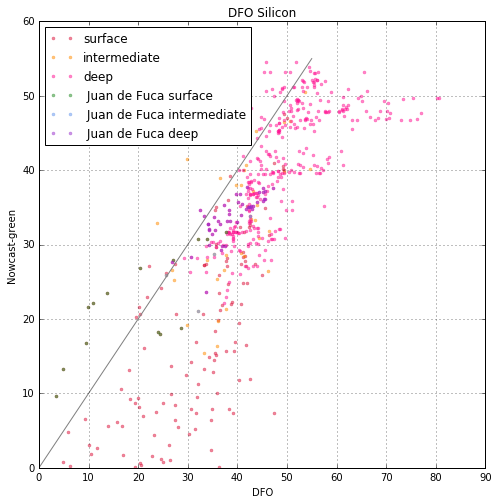

In [42]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(list_of_cs_si[list_of_depths < 15], list_of_model_si[list_of_depths < 15], 
        '.', color = 'Crimson', alpha = 0.5, label = 'surface')
ax.plot(list_of_cs_si[(22 > list_of_depths) & (list_of_depths >= 15)], 
        list_of_model_si[(22 > list_of_depths) & (list_of_depths >= 15)], 
        '.', color = 'DarkOrange', alpha = 0.5, label = 'intermediate')
ax.plot(list_of_cs_si[list_of_depths >= 22], list_of_model_si[list_of_depths >= 22], 
        '.', color = 'DeepPink', alpha = 0.5, label = 'deep')

ax.plot(list_of_cs_si[(list_of_depths < 15) & (list_of_lons < -123.5) & (list_of_lats < 48.6)], 
        list_of_model_si[(list_of_depths < 15) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.6)], 
        '.', color = 'ForestGreen', alpha = 0.5, label = ' Juan de Fuca surface')
ax.plot(list_of_cs_si[(22 > list_of_depths) & (list_of_depths >= 15) 
                      & (list_of_lons < -123.5) & (list_of_lats < 48.6)], 
        list_of_model_si[(22 > list_of_depths) & (list_of_depths >= 15) 
                         & (list_of_lons < -123.5) & (list_of_lats < 48.6)], 
        '.', color = 'CornflowerBlue', alpha = 0.5, label = ' Juan de Fuca intermediate')
ax.plot(list_of_cs_si[(list_of_depths >= 22) & (list_of_lons < -123.5) & (list_of_lats < 48.6)], 
        list_of_model_si[(list_of_depths >= 22) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.6)], 
        '.', color = 'DarkOrchid', alpha = 0.5, label = ' Juan de Fuca deep')

ax.plot(np.arange(0,56), color = 'grey')
ax.grid('on')
ax.set_title('DFO Silicon')
ax.set_xlabel('DFO')
ax.set_ylabel('Nowcast-green');
ax.legend(loc=2)
print('surface bias =  ' + str(-np.mean(list_of_cs_si[list_of_depths < 15]) 
                               + np.mean(list_of_model_si[list_of_depths < 15])))
print('surface RMSE = ' + str(np.sqrt(np.sum((list_of_model_si[list_of_depths < 15] 
                                              - list_of_cs_si[list_of_depths < 15])**2) /
                              len(list_of_cs_si[list_of_depths < 15]))))
xbar = np.mean(list_of_cs_si[list_of_depths < 15])
print('surface Willmott = ' + str(1-(np.sum((list_of_model_si[list_of_depths < 15] 
                                             - list_of_cs_si[list_of_depths < 15])**2)  / 
                             np.sum((np.abs(list_of_model_si[list_of_depths < 15] - xbar) 
                                     + np.abs(list_of_cs_si[list_of_depths < 15] - xbar))**2))))

print('intermediate bias =  ' + str(-np.mean(list_of_cs_si[(22 > list_of_depths) 
                                                           & (list_of_depths >= 15)]) 
                               + np.mean(list_of_model_si[(22 > list_of_depths) 
                                                          & (list_of_depths >= 15)])))
print('intermediate RMSE = ' + str(np.sqrt(np.sum((list_of_model_si[(22 > list_of_depths) 
                                                                    & (list_of_depths >= 15)] 
                                              - list_of_cs_si[(22 > list_of_depths) 
                                                              & (list_of_depths >= 15)])**2) /
                              len(list_of_cs_si[(22 > list_of_depths) & (list_of_depths >= 15)]))))
xbar = np.mean(list_of_cs_si[(22 > list_of_depths) & (list_of_depths >= 15)])
print('intermediate Willmott = ' + str(1-(np.sum((list_of_model_si[(22 > list_of_depths) 
                                                                   & (list_of_depths >= 15)] 
                                             - list_of_cs_si[(22 > list_of_depths) 
                                                             & (list_of_depths >= 15)])**2)  / 
                             np.sum((np.abs(list_of_model_si[(22 > list_of_depths) 
                                                             & (list_of_depths >= 15)] - xbar) 
                                     + np.abs(list_of_cs_si[(22 > list_of_depths) 
                                                            & (list_of_depths >= 15)] - xbar))**2))))

print('deep bias =  ' + str(-np.mean(list_of_cs_si[list_of_depths >= 22]) 
                               + np.mean(list_of_model_si[list_of_depths >= 22])))
print('deep RMSE = ' + str(np.sqrt(np.sum((list_of_model_si[list_of_depths >= 22] 
                                              - list_of_cs_si[list_of_depths >= 22])**2) /
                              len(list_of_cs_si[list_of_depths >= 22]))))
xbar = np.mean(list_of_cs_si[list_of_depths >= 22])
print('deep Willmott = ' + str(1-(np.sum((list_of_model_si[list_of_depths >= 22] 
                                             - list_of_cs_si[list_of_depths >= 22])**2)  / 
                             np.sum((np.abs(list_of_model_si[list_of_depths >= 22] - xbar) 
                                     + np.abs(list_of_cs_si[list_of_depths >= 22] - xbar))**2))))

print('bias =  ' + str(-np.mean(list_of_cs_si) + np.mean(list_of_model_si)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_si - list_of_cs_si)**2) /
                              len(list_of_cs_si))))
xbar = np.mean(list_of_cs_si)
print('Willmott = ' + str(1-(np.sum((list_of_model_si - list_of_cs_si)**2)  / 
                             np.sum((np.abs(list_of_model_si - xbar) 
                                     + np.abs(list_of_cs_si - xbar))**2))))

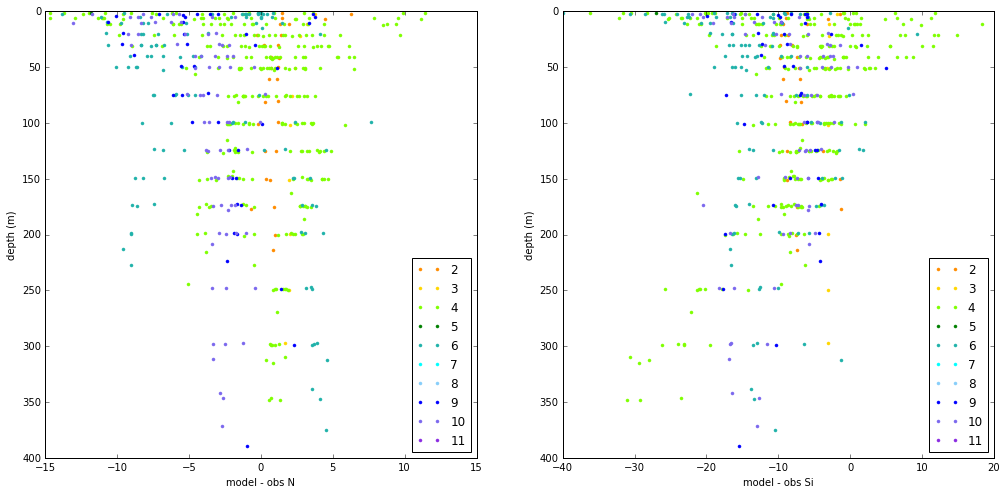

In [43]:
fig, ax = plt.subplots(1,2,figsize = (17,8))
iii=(list_of_datetimes>dt.datetime(2015,2,1))
cols=('crimson','orangered','darkorange','gold','chartreuse','green','lightseagreen','cyan',
      'lightskyblue','blue','mediumslateblue','blueviolet','darkmagenta','fuchsia')
for ii in range(2,12):
    iii=(list_of_datetimes>=dt.datetime(2015,ii,1))&(list_of_datetimes<dt.datetime(2015,ii+1,1))
    ax[0].plot(list_of_model_ni[iii]-list_of_cs_ni[iii], list_of_depths[iii], 
        '.', color = cols[ii],label=str(ii))
    ax[1].plot(list_of_model_si[iii]-list_of_cs_si[iii], list_of_depths[iii], 
        '.', color = cols[ii],label=str(ii))
for axi in (ax[0],ax[1]):
    axi.legend(loc=4)
    axi.set_ylim(400,0)
    axi.set_ylabel('depth (m)')
ax[0].set_xlabel('model - obs N')
ax[1].set_xlabel('model - obs Si')

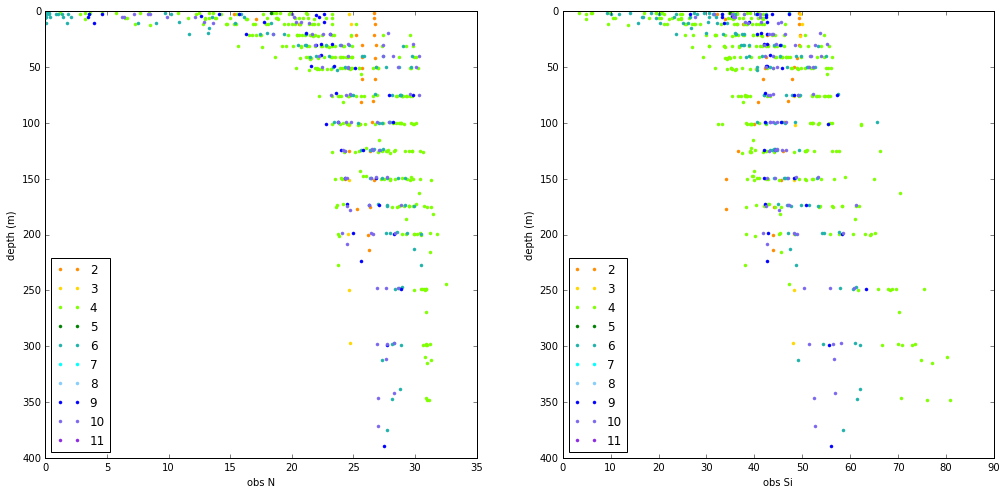

In [44]:
fig, ax = plt.subplots(1,2,figsize = (17,8))
iii=(list_of_datetimes>dt.datetime(2015,2,1))
cols=('crimson','orangered','darkorange','gold','chartreuse','green','lightseagreen','cyan',
      'lightskyblue','blue','mediumslateblue','blueviolet','darkmagenta','fuchsia')
for ii in range(2,12):
    iii=(list_of_datetimes>=dt.datetime(2015,ii,1))&(list_of_datetimes<dt.datetime(2015,ii+1,1))
    ax[0].plot(list_of_cs_ni[iii], list_of_depths[iii], 
        '.', color = cols[ii],label=str(ii))
    ax[1].plot(list_of_cs_si[iii], list_of_depths[iii], 
        '.', color = cols[ii],label=str(ii))
for axi in (ax[0],ax[1]):
    axi.legend(loc=3)
    axi.set_ylim(400,0)
    axi.set_ylabel('depth (m)')
ax[0].set_xlabel('obs N')
ax[1].set_xlabel('obs Si')

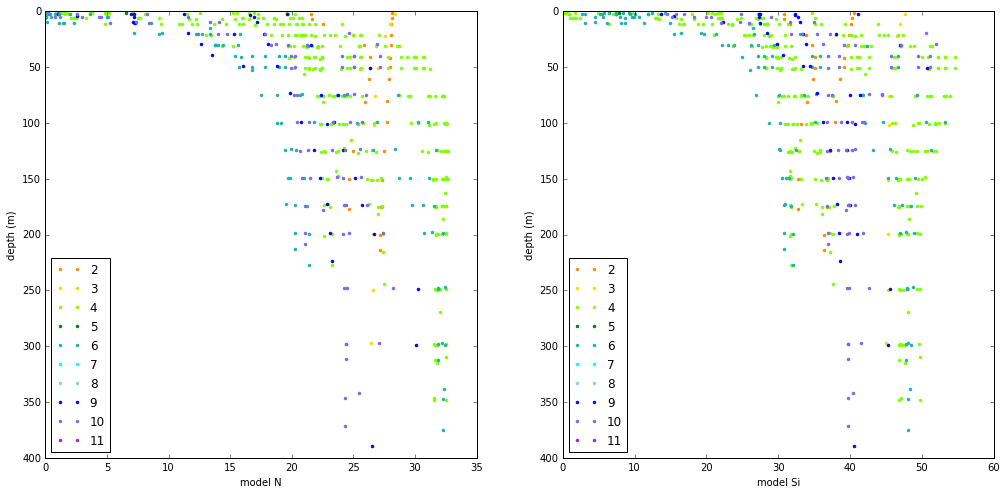

In [45]:
fig, ax = plt.subplots(1,2,figsize = (17,8))
iii=(list_of_datetimes>dt.datetime(2015,2,1))
cols=('crimson','orangered','darkorange','gold','chartreuse','green','lightseagreen','cyan',
      'lightskyblue','blue','mediumslateblue','blueviolet','darkmagenta','fuchsia')
for ii in range(2,12):
    iii=(list_of_datetimes>=dt.datetime(2015,ii,1))&(list_of_datetimes<dt.datetime(2015,ii+1,1))
    ax[0].plot(list_of_model_ni[iii], list_of_depths[iii], 
        '.', color = cols[ii],label=str(ii))
    ax[1].plot(list_of_model_si[iii], list_of_depths[iii], 
        '.', color = cols[ii],label=str(ii))
for axi in (ax[0],ax[1]):
    axi.legend(loc=3)
    axi.set_ylim(400,0)
    axi.set_ylabel('depth (m)')
ax[0].set_xlabel('model N')
ax[1].set_xlabel('model Si')

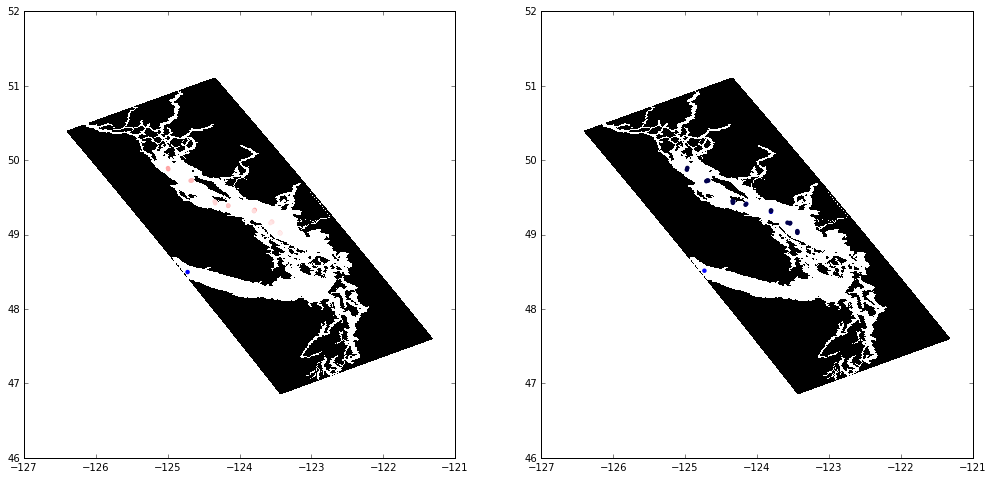

In [46]:
fig, ax = plt.subplots(1,2,figsize = (17,8))
iii=(list_of_datetimes>dt.datetime(2015,2,1))
cmap1=plt.get_cmap('seismic')
ax[0].pcolormesh(lon,lat,tmask[0,0,:,:],cmap=plt.get_cmap('gray'))
ax[1].pcolormesh(lon,lat,tmask[0,0,:,:],cmap=plt.get_cmap('gray'))

iii=(list_of_depths>240)&(list_of_datetimes>=dt.datetime(2015,4,1))&(list_of_datetimes<dt.datetime(2015,5,1))
ax[0].scatter(list_of_lons[iii]+np.random.randn(sum(iii))*.01,list_of_lats[iii]+np.random.randn(sum(iii))*.01, c=list_of_model_ni[iii]-list_of_cs_ni[iii],cmap=cmap1,edgecolors='none',
             vmin=-10,vmax=10)
ax[1].scatter(list_of_lons[iii]+np.random.randn(sum(iii))*.01,list_of_lats[iii]+np.random.randn(sum(iii))*.01, c=list_of_model_si[iii]-list_of_cs_si[iii],cmap=cmap1,edgecolors='none',
             vmin=-20,vmax=20)
#for axi in (ax[0],ax[1]):
    #axi.legend(loc=4)
    #axi.set_ylim(400,0)
    #axi.set_ylabel('depth (m)')
#ax[0].set_xlabel('model - obs N')
#ax[1].set_xlabel('model - obs Si')

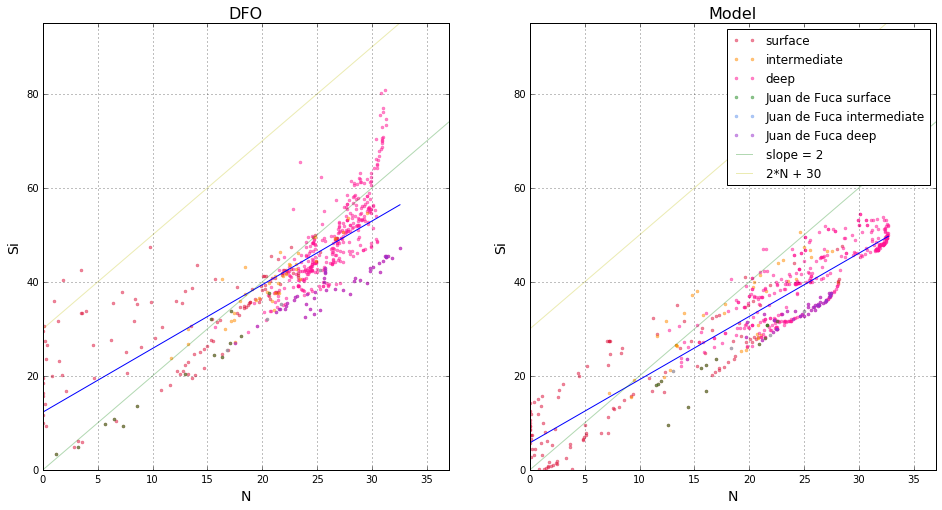

In [47]:
fig, ax = plt.subplots(1,2, figsize = (16,8))
ax[0].plot(list_of_cs_ni[list_of_depths >= 22], list_of_cs_si[list_of_depths >=22], 
           '.', color = 'DeepPink', alpha = 0.5)
ax[0].plot(list_of_cs_ni[list_of_depths < 15], list_of_cs_si[list_of_depths < 15], 
           '.', color = 'Crimson', alpha = 0.5)
ax[0].plot(list_of_cs_ni[(22 > list_of_depths) & (list_of_depths >= 15)], 
           list_of_cs_si[(22 > list_of_depths) & (list_of_depths >= 15)], 
           '.', color = 'DarkOrange', alpha = 0.5)
ax[0].plot(list_of_cs_ni[(list_of_depths >= 22) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.6)], 
           list_of_cs_si[(list_of_depths >= 22) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.6)], 
           '.', color = 'DarkOrchid', alpha = 0.5)
ax[0].plot(list_of_cs_ni[(list_of_depths < 15) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.6)], 
           list_of_cs_si[(list_of_depths < 15) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.6)], 
           '.', color = 'ForestGreen', alpha = 0.5)
ax[0].plot(list_of_cs_ni[(22 > list_of_depths) & (list_of_depths >= 15) 
                         & (list_of_lons < -123.5) & (list_of_lats < 48.6)], 
           list_of_cs_si[(22 > list_of_depths) & (list_of_depths >= 15) 
                         & (list_of_lons < -123.5) & (list_of_lats < 48.6)], 
           '.', color = 'CornflowerBlue', alpha = 0.5)
ax[0].plot(np.unique(list_of_cs_ni), 
           np.poly1d(np.polyfit(list_of_cs_ni, list_of_cs_si, 1))(np.unique(list_of_cs_ni)))
x = np.arange(0,40)
ax[0].plot(x, 2*x, 'g-', alpha = 0.3)
ax[0].plot(x, 2*x+30, 'y-', alpha = 0.3)

ax[1].plot(list_of_model_ni[list_of_depths < 15], list_of_model_si[list_of_depths < 15], 
           '.', color = 'Crimson', alpha = 0.5, label = 'surface')
ax[1].plot(list_of_model_ni[(22 > list_of_depths) & (list_of_depths >= 15)], 
           list_of_model_si[(22 > list_of_depths) & (list_of_depths >= 15)], 
           '.', color = 'DarkOrange', alpha = 0.5, label = 'intermediate')
ax[1].plot(list_of_model_ni[list_of_depths >= 22], list_of_model_si[list_of_depths >=22], 
           '.', color = 'DeepPink', alpha = 0.5, label = 'deep')
ax[1].plot(list_of_model_ni[(list_of_depths < 15) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.6)], 
           list_of_model_si[(list_of_depths < 15) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.6)], 
           '.', color = 'ForestGreen', alpha = 0.5, label = 'Juan de Fuca surface')
ax[1].plot(list_of_model_ni[(22 > list_of_depths) & (list_of_depths >= 15) 
                         & (list_of_lons < -123.5) & (list_of_lats < 48.6)], 
           list_of_model_si[(22 > list_of_depths) & (list_of_depths >= 15) 
                         & (list_of_lons < -123.5) & (list_of_lats < 48.6)], 
           '.', color = 'CornflowerBlue', alpha = 0.5, label = 'Juan de Fuca intermediate')
ax[1].plot(list_of_model_ni[(list_of_depths >= 22) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.6)], 
           list_of_model_si[(list_of_depths >= 22) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.6)], 
           '.', color = 'DarkOrchid', alpha = 0.5, label = 'Juan de Fuca deep')
ax[1].plot(np.unique(list_of_model_ni), 
           np.poly1d(np.polyfit(list_of_model_ni, 
                                list_of_model_si, 1))(np.unique(list_of_model_ni)))
x = np.arange(0,40)
ax[1].plot(x, 2*x, 'g-', alpha = 0.3, label = 'slope = 2')
ax[1].plot(x, 2*x+30, 'y-', alpha = 0.3, label = '2*N + 30')
ax[0].set_title('DFO', fontsize = 16)
ax[1].set_title('Model', fontsize = 16)
for ax in ax:
    ax.grid('on')
    ax.set_ylabel('Si', fontsize = 14)
    ax.set_xlabel('N', fontsize = 14)
    ax.set_ylim(0,95)
    ax.set_xlim(0,37)
plt.legend();

In [48]:
m1, b1 = np.polyfit(list_of_cs_ni, list_of_cs_si, 1)
print('DFO slope = ' + str(m1))
print('DFO y int = ' + str(b1))
m2, b2 = np.polyfit(list_of_model_ni, list_of_model_si, 1)
print('model slope = ' + str(m2))
print('model y int = ' + str(b2))

DFO slope = 1.35535794713
DFO y int = 12.2843009586
model slope = 1.34480142447
model y int = 5.75127096706
